# Direct methods (shooting vs simultaneous)

In [ ]:
!pip install dynamaxsys==0.0.5


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import jax.numpy as jnp
import cvxpy as cp
import matplotlib.pyplot as plt

from dynamaxsys.integrators import DoubleIntegrator2D
from dynamaxsys.base import get_discrete_time_dynamics, get_linearized_dynamics

### Define double integrator dynamics

In [ ]:
dynamics = get_discrete_time_dynamics(DoubleIntegrator2D(), dt=0.1)
state0 = jnp.array([0.0, 0.0, 0.0, 0.0])
control0 = jnp.array([0.0, 0.0])
time = 0.1
dynamics = get_linearized_dynamics(dynamics, state0, control0, time)

x0 = np.array([0., 0., 0., 2.]) # initial state
xgoal = np.array([8., 4., 0., -1.]) # goal state

## Shooting method

In [ ]:
m = 2 # control input dimension
T = 50 # Number of time steps
us = cp.Variable((m, T)) # control inputs <----- only control inputs are optimized
xs = [x0]
objective = 0
constraints = []
for i in range(T):
    u = us[:, i]
    objective += cp.sum_squares(u)
    # dynamics are not a constraint. 
    xnext = dynamics(xs[-1], u) # used to get state at time t+1 in order to get xT at the end.
    xs.append(xnext)
    # Add constraints
    constraints.append(cp.norm(u, 2) <= 2)
    
xT = xs[-1]

# objective += 10*cp.sum_squares(xT - xgoal) # minimize distance to origin
constraints.append(xT == xgoal) # final state constraint

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

np.float64(81.6405878373996)

In [5]:
%timeit problem.solve()

1.95 ms ± 89.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Need to simulate dynamics using optimized controls

In [6]:
def simulate(x0, us, dynamics):
    xs = [x0]
    for u in us.T:
        xnext = dynamics(xs[-1], u)
        xs.append(xnext)
    return np.array(xs)

xs = simulate(x0, us.value, dynamics)

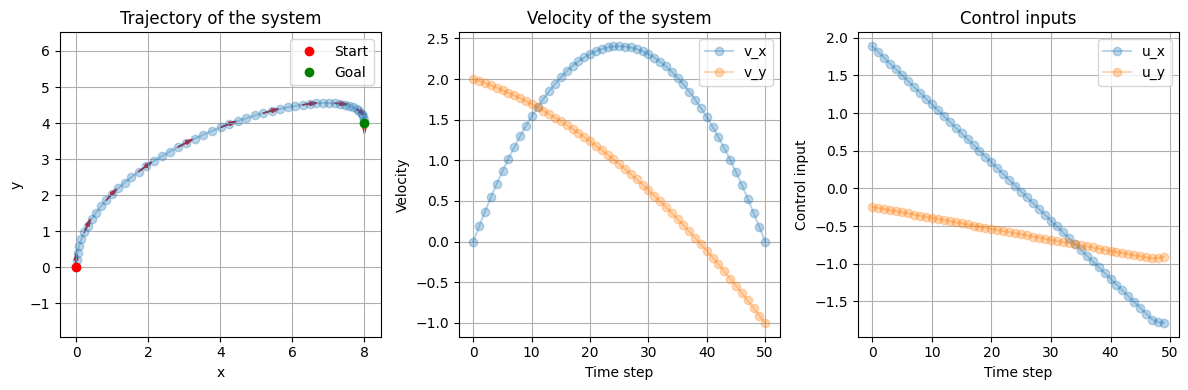

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(xs[:, 0], xs[:, 1], '-o', alpha=0.3)
for i in range(0, len(xs), 5):  # Plot velocity vectors every 5 points
    plt.arrow(xs[i, 0], xs[i, 1], xs[i, 2] * 0.1, xs[i, 3] * 0.1, 
              head_width=0.1, head_length=0.2, fc='red', ec='red')
plt.plot(x0[0], x0[1], 'ro', label='Start')
plt.plot(xgoal[0], xgoal[1], 'go', label='Goal')
plt.title('Trajectory of the system')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('equal')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(xs[:, 2], '-o', alpha=0.3, label='v_x')
plt.plot(xs[:, 3], '-o', alpha=0.3, label='v_y')
plt.title('Velocity of the system')
plt.xlabel('Time step')
plt.ylabel('Velocity')
plt.legend()
# plt.axis('equal')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(us.value[0, :], '-o', alpha=0.3, label='u_x')
plt.plot(us.value[1, :], '-o', alpha=0.3, label='u_y')
plt.title('Control inputs')
plt.xlabel('Time step')
plt.ylabel('Control input')
plt.legend()
# plt.axis('equal')
plt.grid()

plt.tight_layout()
plt.show()


## Simultaneous method

In [ ]:
n = 4
m = 2 # control input dimension
T = 50 # Number of time steps
us = cp.Variable((m, T)) # control inputs 
xs = cp.Variable((n, T+1)) # states
objective = 0
constraints = [xs[:,0] == x0]
for i in range(T):
    u = us[:, i]
    objective += cp.sum_squares(u)
    # dynamics are treated as constraints. Adding to list of constraints.
    constraints.append(xs[:,i+1] == dynamics(xs[:,i], u))
    # Add constraints
    constraints.append(cp.norm(u, 2) <= 2)
    
# objective += 10*cp.sum_squares(xs[:,-1] - xgoal) # minimize distance to origin
constraints.append(xs[:,-1] == xgoal) # final state constraint

problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

np.float64(81.64058783739996)

In [9]:
%timeit problem.solve()

2.58 ms ± 13.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


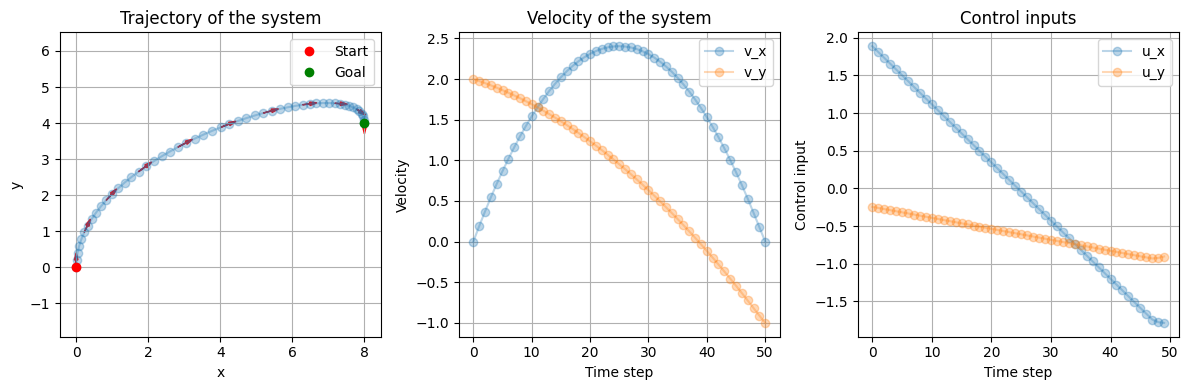

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(xs.value.T[:, 0], xs.value.T[:, 1], '-o', alpha=0.3)
for i in range(0, len(xs.value.T), 5):  # Plot velocity vectors every 5 points
    plt.arrow(xs.value.T[i, 0], xs.value.T[i, 1], xs.value.T[i, 2] * 0.1, xs.value.T[i, 3] * 0.1, 
              head_width=0.1, head_length=0.2, fc='red', ec='red')
plt.plot(x0[0], x0[1], 'ro', label='Start')
plt.plot(xgoal[0], xgoal[1], 'go', label='Goal')
plt.title('Trajectory of the system')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('equal')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(xs.value.T[:, 2], '-o', alpha=0.3, label='v_x')
plt.plot(xs.value.T[:, 3], '-o', alpha=0.3, label='v_y')
plt.title('Velocity of the system')
plt.xlabel('Time step')
plt.ylabel('Velocity')
plt.legend()
# plt.axis('equal')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(us.value[0, :], '-o', alpha=0.3, label='u_x')
plt.plot(us.value[1, :], '-o', alpha=0.3, label='u_y')
plt.title('Control inputs')
plt.xlabel('Time step')
plt.ylabel('Control input')
plt.legend()
# plt.axis('equal')
plt.grid()

plt.tight_layout()
plt.show()


## Questions/comments

- Try solving the problem where the reaching the goal state is treated as a constraint and also try when it is treated as an objective
- With the double integrator, the shooting method and simultaneous method were both convex problems (i.e., could be solved using cvxpy). Is this surprising? 
- Notice that the shooting method ran slightly faster than the simultaneous method, even though the shooting method requires use to simulate the dynamics over the horizon. For this double integrator system, is simulating the dynamics to obtain states an "expensive" process? Why or why not?